In [1]:
import spacetime as st
import numpy as np
import perfplot
import matplotlib.pyplot as plt
import functools

# Combine multiple benchmark data objects with each other
def PerfplotData_append(self, other):
    assert np.array_equal(self.n_range, other.n_range)
    n_range = self.n_range
    timings_s = np.concatenate([self.timings_s, other.timings_s])
    flop = self.flop
    labels = self.labels + other.labels
    xlabel = self.xlabel
    title = self.title
    return perfplot._main.PerfplotData(
        n_range,
        timings_s,
        flop,
        labels,
        xlabel,
        title
    )

perfplot._main.PerfplotData.__add__ = PerfplotData_append

# Function to run multiple different benchmarks with different
# setup functions and combine results. This is needed because
# perfplot does not allow you to specify different setup functions
# for different kernels.
def bench_multiple(m_list, n_list, setup, kernels, labels, xlabel):
    benchmarks = []
    
    for m in m_list:
        benchmarks.append(perfplot.bench(
            n_range=n_list,
            setup=setup(m),
            kernels=kernels(m),
            labels=labels(m),
            xlabel=xlabel,
            equality_check=None,
            show_progress=False
        ))
    return functools.reduce(PerfplotData_append, benchmarks)

In [10]:
nevent_list = [1, 2, 10, 20, 50, 100, 1000, 10_000, 100_000]
ndim_list = [2, 4, 10]

res1 = bench_multiple(
    ndim_list,
    nevent_list,
    setup=lambda ndim: lambda nevent: (
        np.random.rand(nevent, ndim),
        np.random.rand(ndim - 1) * (1/(ndim-1)**0.5)
    ),
    kernels=lambda ndim: [
        lambda a, b: (st.boost(a, b, _old=True)),
    ],
    labels=lambda ndim: [f'boost {ndim}-D'],
    xlabel='num events'
)

res2 = bench_multiple(
    ndim_list,
    nevent_list,
    setup=lambda ndim: lambda nevent: (
        np.random.rand(nevent, ndim),
        np.random.rand(ndim - 1) * (1/(ndim-1)**0.5)
    ),
    kernels=lambda ndim: [
        lambda a, b: (st.boost(a, b)),
    ],
    labels=lambda ndim: [f'boost improved {ndim}-D'],
    xlabel='num events'
)

Output()

Output()

Output()

Output()

Output()

Output()

Text(0.5, 1.0, 'st.boost old vs new impl')

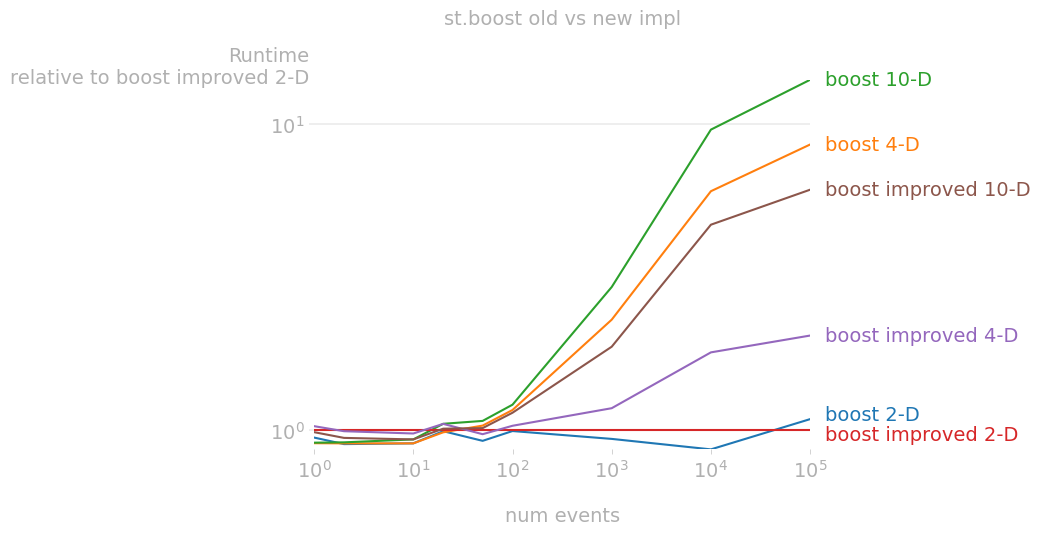

In [11]:
(res1 + res2).plot(logy=True, logx=True, relative_to=3)
ax = plt.gca()
ax.set_title('st.boost old vs new impl')

Text(0.5, 1.0, 'st.boost old vs new impl')

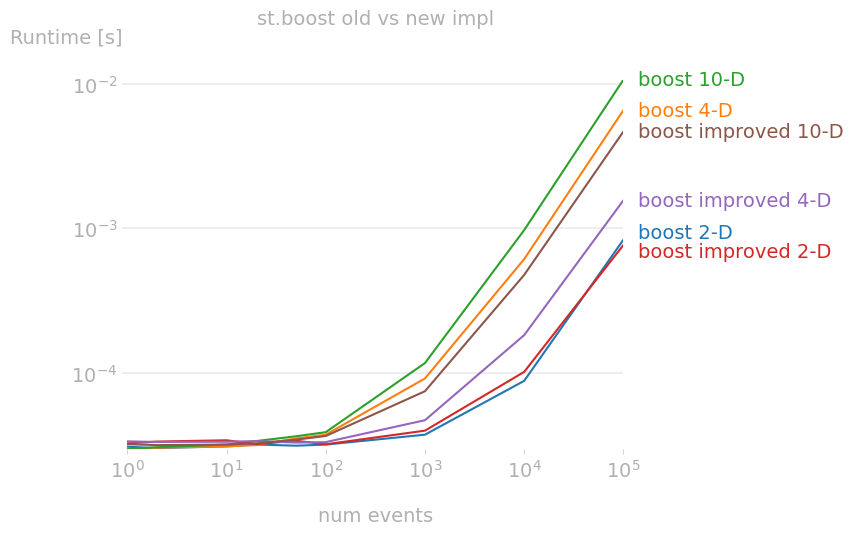

In [12]:
(res1 + res2).plot(logx=True, logy=True)
ax = plt.gca()
ax.set_title('st.boost old vs new impl')

In [2]:

# TODO: Maybe I should make some generator like this available
# in the library
def rand_worldline(nvertices, ndim):
    times = np.cumsum(np.random.rand(nvertices) + 1)[..., np.newaxis] - nvertices / 2
    position_offsets = (2 * np.random.rand(nvertices, ndim - 1) - 1) * (1 / (ndim-1) ** 0.5)
    positions = np.cumsum(position_offsets, axis=0)
    vertices = np.concatenate([times, positions], axis=-1)
    
    past_vel_s = np.random.rand(ndim - 1) * (1/(ndim-1)**0.5)
    future_vel_s = np.random.rand(ndim - 1) * (1/(ndim-1)**0.5)
    
    return st.Worldline(
        vertices,
        past_vel_s=past_vel_s,
        future_vel_s=future_vel_s)

def rand_frame(nworldlines, nvertices, ndim):
    return st.Frame([rand_worldline(nvertices, ndim) for _ in range(nworldlines)])
    

In [3]:
# Benchmark `Frame.boost`


nvertices_list = [1, 2, 10, 20, 50, 100, 1000]
nworldlines_list = [10, 50, 100, 1000]

ndim = 4

res1 = bench_multiple(
    nworldlines_list,
    nvertices_list,
    setup=lambda nworldlines: lambda nvertices: (
        rand_frame(nworldlines, nvertices, ndim),
        np.random.rand(ndim - 1) * (1/(ndim-1)**0.5),
    ),
    kernels=lambda nworldlines: [
        lambda f, v: (f.boost(v)),
    ],
    labels=lambda nworldlines: [f'len-{nworldlines} {ndim}-D'],
    xlabel='num vertices per worldline'
)

res2 = bench_multiple(
    nworldlines_list,
    nvertices_list,
    setup=lambda nworldlines: lambda nvertices: (
        rand_frame(nworldlines, nvertices, ndim),
        np.random.rand(ndim - 1) * (1/(ndim-1)**0.5),
    ),
    kernels=lambda nworldlines: [
        lambda f, v: (f.boost(v, _batched=False)),
    ],
    labels=lambda nworldlines: [f'len-{nworldlines} {ndim}-D no-batch'],
    xlabel='num vertices per worldline'
)

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Text(0.5, 1.0, 'Frame.boost')

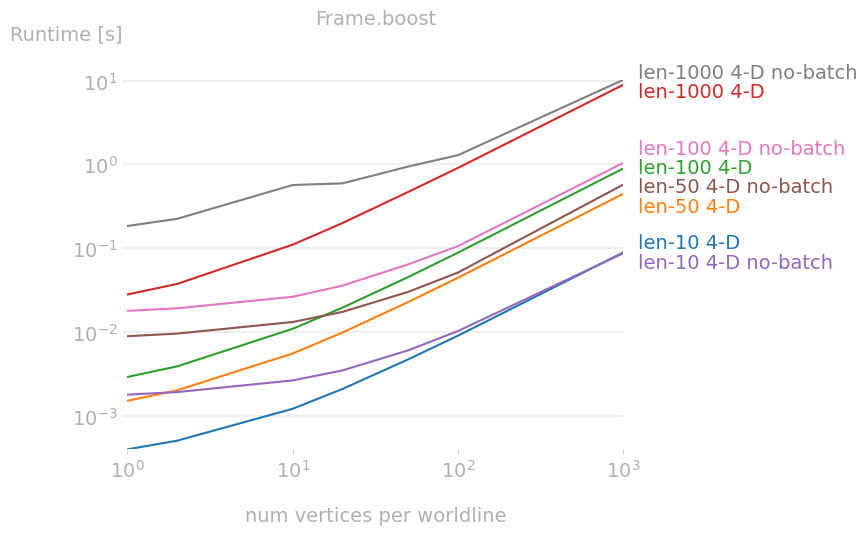

In [4]:
(res1 + res2).plot(logx=True, logy=True)
ax = plt.gca()
ax.set_title('Frame.boost')

In [5]:
# Benchmark `Frame.boost` including pre-offset


nvertices_list = [1, 2, 10, 20, 50, 100, 1000]
nworldlines_list = [10, 50, 100, 1000]

ndim = 4

res1 = bench_multiple(
    nworldlines_list,
    nvertices_list,
    setup=lambda nworldlines: lambda nvertices: (
        rand_frame(nworldlines, nvertices, ndim),
        np.random.rand(ndim - 1) * (1/(ndim-1)**0.5),
        100 * np.random.rand(ndim) - 50,
    ),
    kernels=lambda nworldlines: [
        lambda f, v, d: (f.boost(v, d)),
    ],
    labels=lambda nworldlines: [f'len-{nworldlines} {ndim}-D'],
    xlabel='num vertices per worldline',
)

res2 = bench_multiple(
    nworldlines_list,
    nvertices_list,
    setup=lambda nworldlines: lambda nvertices: (
        rand_frame(nworldlines, nvertices, ndim),
        np.random.rand(ndim - 1) * (1/(ndim-1)**0.5),
        100 * np.random.rand(ndim) - 50,
    ),
    kernels=lambda nworldlines: [
        lambda f, v, d: ((f + d).boost(v, _batched=False)),
    ],
    labels=lambda nworldlines: [f'len-{nworldlines} {ndim}-D no-batch'],
    xlabel='num vertices per worldline'
)

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Text(0.5, 1.0, 'Frame.boost with event_delta_pre')

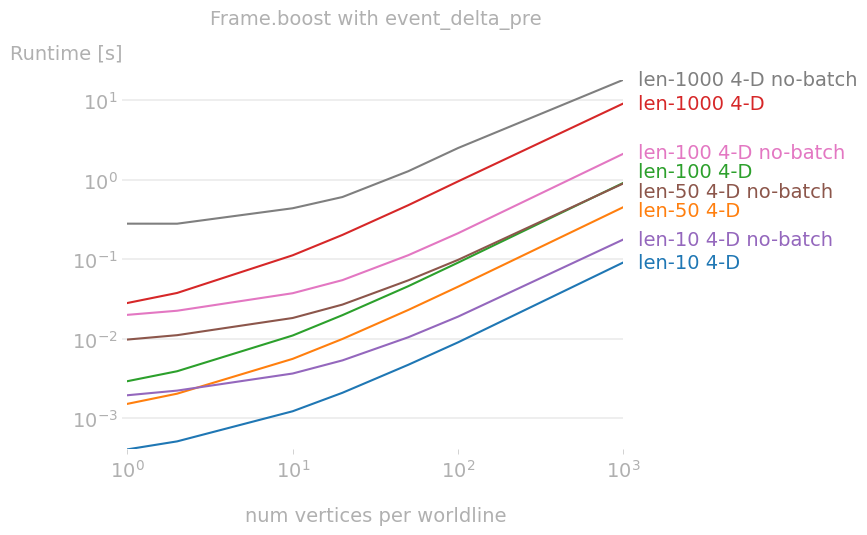

In [6]:
(res1 + res2).plot(logx=True, logy=True)
ax = plt.gca()
ax.set_title('Frame.boost with event_delta_pre')